## Define a class using gensim


In [3]:
import gensim
import os
import nltk
import datetime
import numpy as np
import pandas as pd
import urllib.request
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
from scipy.spatial import distance
from wordcloud import WordCloud
from pprint import pprint
import networkx as nx
import sys
import matplotlib as mp
import time
import math
import seaborn as sns
from scipy.stats import norm
sys.setrecursionlimit(10000)



""""

# 텍스트 추상요약
https://wikidocs.net/72820 -> 텍스트의 추상요약
https://lovit.github.io/nlp/2019/04/30/textrank/ -> 텍스트 요약

"""


from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tag import pos_tag



class Lang_ml:
    SENTENCE_LENGTH = int(300)
    VECTOR_DIMENSION = int(300)
    SENTENCE_NUM = int(5)
    
    def __init__(self):
        
        tmp_bool, tmp_file_path = self.check__model_bin_file()
        if tmp_bool:
            self.wv_model = gensim.models.KeyedVectors.load_word2vec_format(tmp_file_path, binary=True)
            print(f'self.wv_model successful loading!')
        else:
            raise ValueError('no binary modeling exsits in the dir, exit')
        
        self.filter_stop_word = set(stopwords.words('english'))
        self.filter_stem = PorterStemmer()
        self.filter_user_word = []
        self.filter_user_skip_tag = ['IN', 'TO']
        self.filter_user_ok_tag = ['NNP'] # VB excluded
        self.do_print = False
        self.result_print = True
        
        
        # variables for sentence
        self.SENTENCE_all = []
        self.SENTENCE_reduced = []
    
    def check__model_bin_file(self):
        tmp_cur_path = os.getcwd().replace('/','\\')
        tmp_model_file_path = tmp_cur_path + '\\' + 'GoogleNews-vectors-negative300.bin'
        if os.path.isfile(tmp_model_file_path):
            return True, tmp_model_file_path
        else:
            return False, tmp_model_file_path
    
    def split_sentence(self, paragraph):
        
        return sent_tokenize(paragraph)
    
    def filter_sentence(self, sentence):
        bool_append_main_word=False
        print_result = False
        
        # return list
        return_vect_list = []
        
        # tokenize
        tokenize_list = word_tokenize(sentence)
        
        # tagging
        tag_list = pos_tag(tokenize_list) # tuple 형태 (x, y) / y is tag
        
        if self.do_print:
            print(f'tag_list : {tag_list}')
        
        # clipping unwanted words
        filter_list =[]
        for tag in tag_list:
            if (   tag[0] in self.filter_stop_word \
                or tag[0] in self.filter_user_word \
                or not (tag[0].isalpha()) \
               ): # isalpha, only words are allowed!
                pass
            elif tag[1] in self.filter_user_skip_tag:
                pass
            elif tag[1] in self.filter_user_ok_tag:
                filter_list.append(tag[0])
            else:
                if 'VB' in tag[1]:
                    filter_list.append( self.filter_stem.stem(tag[0]) )
                else:
                    filter_list.append(tag[0])
        if len(filter_list) == 0:
            return None # not usable
        else:
            pass
        
        
        # @ reduce into 300 words
        if len(filter_list) >= self.SENTENCE_LENGTH :
            if bool_append_main_word:
                filter_list = filter_list[:self.SENTENCE_LENGTH - 1]
            else:
                filter_list = filter_list[:self.SENTENCE_LENGTH]
        else:
            pass
        
        # @ append main_word for future usage
        if bool_append_main_word:
            filter_list.insert(0, main_word)
        else:
            pass
        
        if self.do_print:
            print(f'filter_list : {filter_list}')
        
        # @ main_word to unique vector, convert non exisiting vector to zeros
        for word in filter_list:
            if word in self.wv_model:
                return_vect_list.append(self.wv_model[word].tolist())
                if self.do_print:
                    print(f'{word} __ is in wv.model')
            else:
                if self.do_print:
                    print(f'{word} __ is not in wv.model')
                if bool_append_main_word:
                    if word == main_word:
                        return_vect_list.append( \
                                        np.full(shape=self.VECTOR_DIMENSION,fill_value=1,dtype=np.int).tolist())
                    else:
                        
                        return_vect_list.append( \
                                        np.full(shape=self.VECTOR_DIMENSION,fill_value=0.5).tolist())
                else:
                    
                    return_vect_list.append( \
                                    np.full(shape=self.VECTOR_DIMENSION,fill_value=0.5).tolist())                                    
        
        # @ zero padding
        for i in range(0, self.SENTENCE_LENGTH - len(return_vect_list), 1 ):
            return_vect_list.append(np.zeros(self.VECTOR_DIMENSION).tolist())
            
        if print_result:
            pass
            
            
        return return_vect_list
    
    def calc_score(self, sim_matrix):
        nx_graph = nx.from_numpy_array(sim_matrix)
        #scores = nx.pagerank(nx_graph)
        #scores = nx.pagerank_numpy(nx_graph)
        scores = nx.pagerank_scipy(nx_graph)
        max_score = 0
        return_list = list(zip(scores.keys(), scores.values()))
        
        for sent in return_list:
            if sent[1] >= max_score:
                max_score = sent[1]
        if self.do_print:
            print(f'scores calculated in calc_socre : {scores}')
            print(f'made return_list : {return_list}')
        
        return return_list, max_score
        
        
    
    def calc_sim_matrix(self, in_mean_sentence):
        
        mean_sentence = np.asarray(in_mean_sentence)
        
        sim_mat = np.zeros([len(mean_sentence), len(mean_sentence)])
        em_dim = self.VECTOR_DIMENSION
        
        for i in range(len(mean_sentence)):
            for j in range(len(mean_sentence)):
                tmp_calc_val = \
                cosine_similarity(\
                    mean_sentence[i].reshape(1, em_dim),
                    mean_sentence[j].reshape(1, em_dim))[0,0]
                tmp_calc_val = (1 - tmp_calc_val)/2
                sim_mat[i][j] = tmp_calc_val
        if self.do_print:
            print(f'pprint ------->')
            pprint(sim_mat, indent=4, width=20)
        
        return sim_mat
     
    def mean_vect_sentence(self, sentence):
        if len(sentence) != 0:
            
            return [sum(word_vec)/len(word_vec) for word_vec in sentence ]
            
        else:
            return np.zeros(len(sentence)).tolist() 
    
    def get_result(self, ori_sentence, key_score_list, cluster_list):
        
        tmp_dict = {}
        result_index = []
        
        if self.result_print:
            print('original : \n')
            for sent in ori_sentence:
                print(sent)
            print('')
        
        
        
        for i in range(len(cluster_list)):
            if cluster_list[i] not in tmp_dict :
                tmp_dict[cluster_list[i]] = []
                
            tmp_dict[cluster_list[i]].append(key_score_list[i])
        
        for key in tmp_dict:
            if self.do_print:
                print(f'before sort tmp_dict[key] : {tmp_dict[key]}')
            tmp_dict[key].sort(reverse=True, key = lambda x:x[1])
            if self.do_print:
                print(f'after sort tmp_dict[key] : {tmp_dict[key]}')
        
        
        for key in tmp_dict:
            result_index.append(tmp_dict[key][0][0])
        result_index.sort()
        
        if self.result_print:
            print('reduced : \n')
            for index in result_index :
                print(ori_sentence[index])
            print('')
        
        
        return result_index
    
    def gen_wordcloud(self, ori_sentence, result_index):
        
        tmp_list = list()
        for sentence in ori_sentence:
            tokenize_list = word_tokenize(sentence)
            tag_list = pos_tag(tokenize_list)
            filter_tag = [  ]
            for item in tag_list:
                if item[1] in ['NN','NNP', 'NNS']:
                    filter_tag.append(item[0])
            tmp_list.extend(filter_tag)
        
        
        word_cloud = WordCloud().generate(  ' '.join(tmp_list)  )
        
        if self.do_print:
            print(f'word_cloud : {word_cloud}')
            print(f'word_cloud.words_ : {word_cloud.words_}')
            print(f'type(word_cloud.words_) : {type(word_cloud.words_)}')
        
        wc_dict= word_cloud.words_
        
        wc_raw_list = list( zip(wc_dict.keys(), wc_dict.values()) )
    
        if self.do_print:
            print(f'wc_raw_list : {wc_raw_list}')
        
        wc_list = sorted( wc_raw_list, 
                         reverse=True, 
                         key=lambda x: x[1])
        
        if self.result_print:
            
            wc_list_cut = wc_list[  : int(min(5, int( len(wc_list)*0.1 )))  ]
            print(f'wc_list_cut - keyword : {wc_list_cut}')
        
        return wc_list
        
    def paragraph_sentence(self, paragraph):
        
        start_time = datetime.datetime.now()

        
        tmp_splitted_sentence = self.split_sentence(paragraph)
        tmp_vectorized_sentence = list(map( self.filter_sentence , tmp_splitted_sentence ))
        tmp_vectorized_sentence = [ ori for ori in tmp_vectorized_sentence if ori != None ]
        tmp_mean_sentence = list(map(self.mean_vect_sentence, tmp_vectorized_sentence))
        tmp_sim_matrix = self.calc_sim_matrix(tmp_mean_sentence)
        tmp_calc_score_list, tmp_max_score = self.calc_score(tmp_sim_matrix) 

        

        tmp_np_calc_score = np.asarray([ [score/tmp_max_score, 1 ] for key_num, score in tmp_calc_score_list])
        if self.do_print:
            print(f'tmp_max_score : {tmp_max_score}')
            print(f'tmp_np_calc_score : {tmp_np_calc_score}')

        tmp_calc_dist = distance.cdist(tmp_np_calc_score, tmp_np_calc_score, 'euclidean')
        calc_dist = list(set([j for num, sub in enumerate(tmp_calc_dist) for j in sub if num <= 40]))
        calc_dist.sort()
        calc_dist.pop(0)

        
        if self.result_print:
            %matplotlib inline
            sns.distplot(calc_dist)
            mp.pyplot.show()

        mu, std = norm.fit(calc_dist)
        targEps = norm.ppf(q=0.1, loc=mu, scale=std) # 0.26 -> real previous 0.2

        
        if self.result_print:
            print(f'targEps : {targEps}')
        if targEps < 0:
            targEps = abs(targEps)

        num_samp = max( int(math.log(len(tmp_splitted_sentence))) - 1, 2 )
        if self.result_print:
            print(f'length of whole paragraph : {len(tmp_splitted_sentence)}')
            print(f'num_samp : {num_samp }')
            
        db = DBSCAN(eps=targEps, min_samples=num_samp, metric='euclidean')
        y_db_res = db.fit_predict(tmp_np_calc_score)
        if self.result_print:
            print(f'elapsed for DBSCAN : {(datetime.datetime.now() - start_time)}')
            print(f'len of cluster : {len(set(y_db_res))}')
            if self.do_print:
                print(f'y_db_res : {y_db_res}')

            %matplotlib inline
            mp.pyplot.scatter(*np.transpose(tmp_np_calc_score), c=y_db_res)
            mp.pyplot.show()

        result_index = self.get_result(tmp_splitted_sentence, tmp_calc_score_list, y_db_res)
        key_words = self.gen_wordcloud(tmp_splitted_sentence, result_index)

        

print(f'done! : {datetime.datetime.now()}')

done! : 2020-12-22 15:11:15.049474


self.wv_model successful loading!


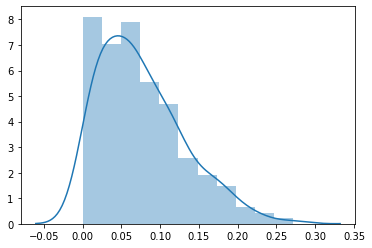

targEps : 0.006192422902081371
length of whole paragraph : 20
num_samp : 2
elapsed for DBSCAN : 0:00:00.369022
len of cluster : 6


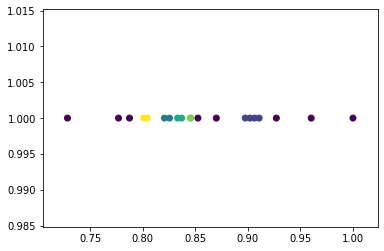

original : 

Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.
The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales.
TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn.
Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.
Time Warner said on Friday that it now owns 8% of search-engine Google.
But its own internet business, AOL, had has mixed fortunes.
It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters.
However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues.
It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to

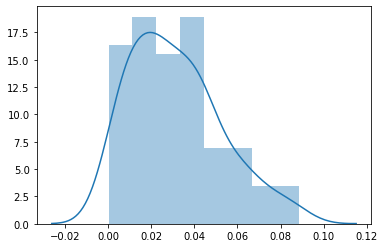

targEps : 0.004506656727537708
length of whole paragraph : 15
num_samp : 2
elapsed for DBSCAN : 0:00:00.301230
len of cluster : 5


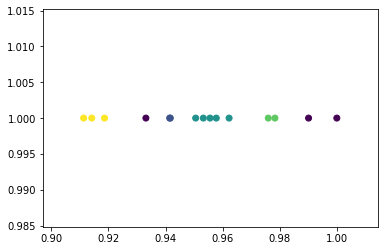

original : 

Dollar gains on Greenspan speech

The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.
And Alan Greenspan highlighted the US government's willingness to curb spending and rising household savings as factors which may help to reduce it.
In late trading in New York, the dollar reached $1.2871 against the euro, from $1.2974 on Thursday.
Market concerns about the deficit has hit the greenback in recent months.
On Friday, Federal Reserve chairman Mr Greenspan's speech in London ahead of the meeting of G7 finance ministers sent the dollar higher after it had earlier tumbled on the back of worse-than-expected US jobs data.
"I think the chairman's taking a much more sanguine view on the current account deficit than he's taken for some time," said Robert Sinche, head of currency strategy at Bank of America in New York.
"He's taking a longer-term view, laying out a set of conditions

In [5]:
def print_files_in_dir(root_dir_list, root_file_list):
    dir_under_root_list = []
    file_under_root_list = root_file_list
    
    for root_dir in root_dir_list:

        files = os.listdir(root_dir)
        
        for file in files:
            path = os.path.join(root_dir, file)
            #print(prefix + path)
            if os.path.isdir(path):
                dir_under_root_list.append(path)
                
            elif os.path.isfile(path):
                file_under_root_list.append(path)
    
    if len(dir_under_root_list) == 0:
        return file_under_root_list
    else:
        return print_files_in_dir(dir_under_root_list, file_under_root_list)

def main():
    model = Lang_ml()

    work_dir = os.getcwd().replace('/','\\')
    news_dir = work_dir + '\\' + 'bbc'


    return_list = print_files_in_dir([news_dir], [])

    bool_break = False        
    for file_paths in return_list:
        tmp_whole_paragraph = ''
        with open(file_paths, 'r') as file:
            while not bool_break:
                line = file.readline()
                if not line: break

                else:
                    tmp_whole_paragraph += line
            model.paragraph_sentence(tmp_whole_paragraph)
            tmp_input = input('iter next line..? x or X to exit')

            if tmp_input in ['x', 'X']:
                bool_break = True
                break    

        if bool_break == True: # for loop
            break
    print('done...!')

if __name__ == '__main__':
    main()

In [6]:
print(f'starting !!  -> {datetime.datetime.now()}')
start_time = datetime.datetime.now()
model = Lang_ml()
print(f'elapsed time of loading model : {datetime.datetime.now() - start_time}')

starting !!  -> 2020-12-22 15:17:29.938843
self.wv_model successful loading!
elapsed time of loading model : 0:01:10.863614


## Article 1
- Max Kozlov Dec 16, 2020
- https://www.the-scientist.com/news-opinion/new-sars-cov-2-variant-spreading-rapidly-in-uk-68292

article content? : As public health officials worldwide mount vaccination campaigns against COVID-19, a new SARS-CoV-2 variant has rapidly taken hold in the UK, leading scientists to investigate if it carries any implications for the transmissibility of the virus, severity of infection, and success of a vaccine, though experts say it is unlikely to hamper vaccination efforts.   As of December 13, 1,108 COVID-19 cases with the new variant had been identified, predominantly in the south and east of England, says Public Health England in a statement on Monday (December 14). “High numbers of cases of the variant virus have been observed in some areas where there is also a high incidence of COVID-19,” the statement notes. “It is not yet known whether the variant is responsible for these increased numbers of cases.”  “We are still dealing with very thin evidence at the moment about this variant,” Sharon Peacock, the director of the UK COVID-19 Genomics Consortium (COG-UK), which randomly seq

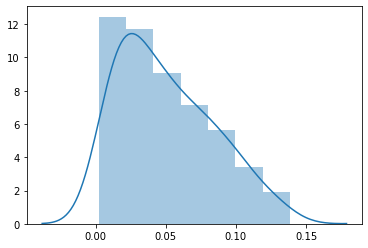

targEps : 0.007088613653065706
length of whole paragraph : 17
num_samp : 2
elapsed for DBSCAN : 0:00:00.314163
len of cluster : 6


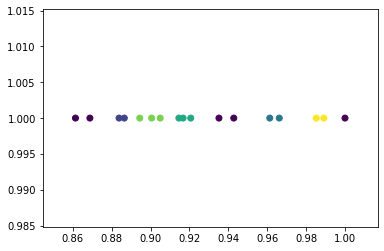

original : 

As public health officials worldwide mount vaccination campaigns against COVID-19, a new SARS-CoV-2 variant has rapidly taken hold in the UK, leading scientists to investigate if it carries any implications for the transmissibility of the virus, severity of infection, and success of a vaccine, though experts say it is unlikely to hamper vaccination efforts.
As of December 13, 1,108 COVID-19 cases with the new variant had been identified, predominantly in the south and east of England, says Public Health England in a statement on Monday (December 14).
“High numbers of cases of the variant virus have been observed in some areas where there is also a high incidence of COVID-19,” the statement notes.
“It is not yet known whether the variant is responsible for these increased numbers of cases.”  “We are still dealing with very thin evidence at the moment about this variant,” Sharon Peacock, the director of the UK COVID-19 Genomics Consortium (COG-UK), which randomly sequences p

In [7]:
tmp_input = input('article content? : ')
model.paragraph_sentence(tmp_input)


## Article 2
- Martin Brueckner April 17, 2018 1.48pm AEST
- https://theconversation.com/not-so-fast-why-the-electric-vehicle-revolution-will-bring-problems-of-its-own-94980

article content? : After years of being derided as a joke by car manufacturers and the public, interest in electric vehicles has increased sharply as governments around the world move to ban petrol and diesel cars.  We have seen a tremendous rise in availability, especially at the premium end of the market, where Tesla is giving established brands a run for their money. Electric cars are likely to penetrate the rest of the market quickly too. Prices should be on par with conventional cars by 2025.  Electric cars are praised as the answer to questions of green and clean mobility. But the overall sustainability of electric vehicles is far from clear. On closer examination, our entire transport paradigm may need to be rethought.  Compared with combustion engines, electric transport has obvious advantages for emissions and human health. Transport is responsible for around 23% of energy-related carbon dioxide emissions globally. This is expected to double by 2050.  Motor vehicles also put a

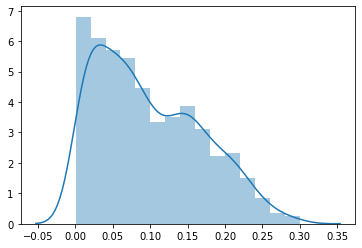

targEps : 0.00812093883383562
length of whole paragraph : 53
num_samp : 2
elapsed for DBSCAN : 0:00:01.094087
len of cluster : 11


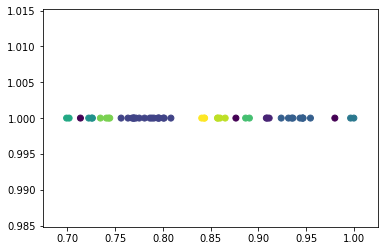

original : 

After years of being derided as a joke by car manufacturers and the public, interest in electric vehicles has increased sharply as governments around the world move to ban petrol and diesel cars.
We have seen a tremendous rise in availability, especially at the premium end of the market, where Tesla is giving established brands a run for their money.
Electric cars are likely to penetrate the rest of the market quickly too.
Prices should be on par with conventional cars by 2025.
Electric cars are praised as the answer to questions of green and clean mobility.
But the overall sustainability of electric vehicles is far from clear.
On closer examination, our entire transport paradigm may need to be rethought.
Compared with combustion engines, electric transport has obvious advantages for emissions and human health.
Transport is responsible for around 23% of energy-related carbon dioxide emissions globally.
This is expected to double by 2050.
Motor vehicles also put a burden on

In [8]:
tmp_input = input('article content? : ')
model.paragraph_sentence(tmp_input)

## Article 3
- Martin Brueckner December, 22, 2020
- https://www.bbc.com/news/world-us-canada-55386947

article content? : The cyber-security firm that identified the large-scale hacking of US government agencies says it "genuinely impacted" around 50 organisations.  Kevin Mandia, CEO of FireEye, said that while some 18,000 organisations had the malicious code in their networks, it was the 50 who suffered major breaches.  The US Treasury and departments of homeland security, state and defence are known to have been targeted.  US Secretary of State Mike Pompeo has blamed Russia for the hack.  So too have the chairs of the Senate and House of Representatives' intelligence committees.  However, President Trump cast doubt on Russia's role in two tweets on Saturday, hinting instead at Chinese involvement.  Mr Mandia told CBS News that the cyber attack "was very consistent" with what US officials know about the work of Russia's foreign intelligence agency, the SVR.  "I think these are folks that we've responded to in the '90s, in the early 2000s. It's a continuing game in cyberspace," he said.

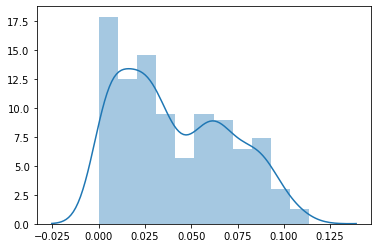

targEps : 0.0032759759270348868
length of whole paragraph : 38
num_samp : 2
elapsed for DBSCAN : 0:00:00.696142
len of cluster : 8


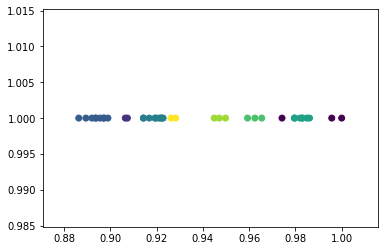

original : 

The cyber-security firm that identified the large-scale hacking of US government agencies says it "genuinely impacted" around 50 organisations.
Kevin Mandia, CEO of FireEye, said that while some 18,000 organisations had the malicious code in their networks, it was the 50 who suffered major breaches.
The US Treasury and departments of homeland security, state and defence are known to have been targeted.
US Secretary of State Mike Pompeo has blamed Russia for the hack.
So too have the chairs of the Senate and House of Representatives' intelligence committees.
However, President Trump cast doubt on Russia's role in two tweets on Saturday, hinting instead at Chinese involvement.
Mr Mandia told CBS News that the cyber attack "was very consistent" with what US officials know about the work of Russia's foreign intelligence agency, the SVR.
"I think these are folks that we've responded to in the '90s, in the early 2000s.
It's a continuing game in cyberspace," he said.
He said the 

In [9]:
tmp_input = input('article content? : ')
model.paragraph_sentence(tmp_input)